# Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением **F1-меры**. Чтобы сдать проект успешно, нужно довести метрику до **0.59**. Проверьте F1-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.




# Загрузка данных

In [177]:
# импорт необходимых для проекта библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st 
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle


In [178]:

# импорт файлов из предполагаемых директорий
pth1 = 'Churn.csv'
pth2 = './datasets/Churn.csv'
pth3 = '/datasets/Churn.csv'
pth4 = './Churn.csv'
pth5= '/content/drive/MyDrive/Colab Notebooks/datasets/Churn.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
elif os.path.exists(pth3):
    df = pd.read_csv(pth3)
elif os.path.exists(pth4):
    df = pd.read_csv(pth4)
elif os.path.exists(pth5):
    df = pd.read_csv(pth5)
else:
    print("Проверьте правильность пути к датасету")
# краткий обзор датасета
display(df.head())
display(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

# Подготовка данных

## Приводим названия признаков к порядку



In [179]:
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited']



## Заполняем пропуски в признаке tenure и готовим датасет к обучению

909 пропущенных значений случайны скорее всего случайны, мы заполним их медианами. 
Также удалим столбцы с фамилиям, номером строки и айди клиента т.к. они не несут ценной информации для поставленной задачи

In [180]:
# print(df[df['tenure'].isna()])
df['tenure'] =  df['tenure'].fillna(df['tenure'].median())
df_prep = df.drop('surname', axis=1) 
df_prep = df_prep.drop('row_number', axis = 1) 
df_prep = df_prep.drop('customer_id',axis = 1)

## Преобразуем категориальные признаки в численные
Не забываем про дамми-ловушку

In [181]:
df_prep = pd.get_dummies(df_prep, drop_first=True) # преобразуем категориальные признаки в численные, не забыв про дамми-ловушку
df_prep.info() # убеждаемся, что преобразование прошло успешно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  float64
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   geography_Germany  10000 non-null  uint8  
 10  geography_Spain    10000 non-null  uint8  
 11  gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


## Подготовка к обучению

In [182]:
features = df_prep.drop('exited', axis=1)
target = df_prep['exited']
# Создаем тренировочную и валидационной выборки
features_train, features_valid, target_train, target_valid= train_test_split(features, target, test_size=0.25, random_state=12345) 
# Создаем тестовую выборку
features_train, features_test, target_train, target_test= train_test_split(features_train, target_train, test_size=0.25, random_state=12345) 


In [183]:
# код ревьюера
display('Тренировочная:', features_train.shape)
display('Валидационная:', features_valid.shape)
display('Тестовая:', features_test.shape)

'Тренировочная:'

(5625, 11)

'Валидационная:'

(2500, 11)

'Тестовая:'

(1875, 11)

## Приводим тестовую и валидационную выборки к единому размеру

In [184]:
features_test_size = features_test.shape[0]
features_valid = shuffle(features_valid, random_state=12345)[:features_test_size]

target_test_size = target_test.shape[0]
target_valid = shuffle(target_valid, random_state=12345)[:target_test_size]


display('Тренировочная:', features_train.shape)
display('Валидационная:', features_valid.shape)
display('Тестовая:', features_test.shape)

'Тренировочная:'

(5625, 11)

'Валидационная:'

(1875, 11)

'Тестовая:'

(1875, 11)

# Исследуйте баланс классов, обучите модель без учёта дисбаланса. 
Кратко опишите выводы.


In [185]:
print('Баланс классов:', target.value_counts())

Баланс классов: 0    7963
1    2037
Name: exited, dtype: int64


Очвидно Отрицательного класса намного больше, чем положительного

## Модель Дерева решений

In [186]:
def dtc(features, target):
    best_model_dtc = None
    best_depth = 0
    best_score_dtc = 0 
    for splitter in ["best", "random"]:
        for criterion in ["gini", "entropy"]:
            for depth in range(1, 16):
                model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, random_state=12345, max_depth=depth)
                model.fit(features, target) 
                predicted_valid = model.predict(features_valid)
                score = f1_score(target_valid, predicted_valid)
                if score > best_score_dtc:
                    best_model_dtc = model
                    best_score_dtc = score
                    best_depth_dtc = depth
                    best_criterion_dtc = criterion
                    best_splitter_dtc = splitter
    print("Наилучшее F1 модели дерева решений на полученых даных:", best_score_dtc, "При глубине:", best_depth_dtc, "При параметре criterion:", best_criterion_dtc, "При параметре splitter:", best_splitter_dtc)
print(dtc(features_train, target_train))


Наилучшее F1 модели дерева решений на полученых даных: 0.5525902668759812 При глубине: 8 При параметре criterion: entropy При параметре splitter: best
None


## Модель случайного леса

In [187]:
def rfc(features, target):
    best_model_rfc = None
    best_score_rfc = 0
    best_est_rfc = 0
    for criterion in ["gini", "entropy"]:
        for depth in range(1, 21):
            for est in range(1, 21):
                model = RandomForestClassifier(criterion = criterion, max_depth=depth, random_state=12345, n_estimators=est)
                model.fit(features, target) 
                predicted_valid = model.predict(features_valid)
                score = f1_score(target_valid, predicted_valid)
                if score > best_score_rfc:
                    best_model_rfc = model
                    best_score_rfc = score
                    best_depth_rfc = depth
                    best_criterion_rfc = criterion
                    best_est_rfc = est
    print("Наилучшее F1 модели случайного леса на полученных данных:", best_score_rfc, "При глубине:", best_depth_rfc, "При параметре criterion:", best_criterion_rfc, "При параметре n_estimators:", best_est_rfc)
print(rfc(features_train, target_train))

Наилучшее F1 модели случайного леса на полученных данных: 0.570162481536189 При глубине: 18 При параметре criterion: gini При параметре n_estimators: 9
None


## Логистическая регрессия


In [188]:
def lr(features, target):
    best_model_lr = None
    best_score_lr = 0
    best_iter_lr = 0
    for i in range(10, 150, 10):
        model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=i)
        model.fit(features, target)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_score_lr:
            best_model_lr = model
            best_score_lr = score
            best_iter_lr = i
    print("Наилучшее F1 модели логистической регрессии:", best_score_lr, "При параметре max_iter:", best_iter_lr)
print(lr(features_train, target_train))

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Наилучшее F1 модели логистической регрессии: 0.09954751131221719 При параметре max_iter: 30
None


> Резюмируя проделанную работу над обучением трех моделей классификации **без балансировки классов** можно сказать, что ни одна из моделей не достигла поставленной задачи. Все модели одинаково плохо различают отрицательные и положительные классы.

# Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.


## Устраняем дисбаланс классов, применяя метод upsampling


In [189]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print('Смотрим баланс классов',target_upsampled.value_counts())



Смотрим баланс классов 0    4503
1    4488
Name: exited, dtype: int64


## Устраняем дисбаланс классов, применяя downsampling

In [190]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print('Смотрим баланс классов',target_downsampled.value_counts())

Смотрим баланс классов 0    1126
1    1122
Name: exited, dtype: int64


# Тренируем и настраиваем модели на сбалансированных данных

## Модель дерева решений

In [191]:
# Тренируем на upsampled данных
print('Результат тренировки модели дерева решений на upsampled данных')
print(dtc(features_upsampled, target_upsampled))
print()
# Тренируем на downsampled данных
print('Результат тренировки модели дерева решений на downsampled данных')
print(dtc(features_downsampled, target_downsampled))
print()
# Тренируем на сбалансированных классах
best_model_dtc = None
best_depth = 0
best_score_dtc = 0 
for splitter in ["best", "random"]:
    for criterion in ["gini", "entropy"]:
        for depth in range(1, 16):
            model = DecisionTreeClassifier(criterion=criterion, class_weight='balanced', splitter=splitter, random_state=12345, max_depth=depth)
            model.fit(features_train, target_train) 
            predicted_valid = model.predict(features_valid)
            score = f1_score(target_valid, predicted_valid)
            if score > best_score_dtc:
                best_model_dtc = model
                best_score_dtc = score
                best_depth_dtc = depth
                best_criterion_dtc = criterion
                best_splitter_dtc = splitter
print("Наилучшее F1 модели дерева решений на взвешенных даных:", best_score_dtc, "При глубине:", best_depth_dtc, "При параметре criterion:", best_criterion_dtc, "При параметре splitter:", best_splitter_dtc)


Результат тренировки модели дерева решений на upsampled данных
Наилучшее F1 модели дерева решений на полученых даных: 0.5964523281596452 При глубине: 8 При параметре criterion: gini При параметре splitter: random
None

Результат тренировки модели дерева решений на downsampled данных
Наилучшее F1 модели дерева решений на полученых даных: 0.6003898635477583 При глубине: 6 При параметре criterion: entropy При параметре splitter: best
None

Наилучшее F1 модели дерева решений на взвешенных даных: 0.5916069600818834 При глубине: 8 При параметре criterion: entropy При параметре splitter: random


## Модель случайного леса

In [192]:
# Тренируем на downsampled данных
print('Результат тренировки модели случайного леса на upsampled данных')
print(rfc(features_upsampled, target_upsampled))
print()
# Тренируем на downsampled данных
print('Результат тренировки модели случайного леса на downsampled данных')
print(rfc(features_downsampled, target_downsampled))
print()

# Тренируем на взвешенных данных
best_model_rfc = None
best_score_rfc = 0
best_est_rfc = 0
for criterion in ["gini", "entropy"]:
    for depth in range(1, 21):
        for est in range(1, 21):
            model = RandomForestClassifier(criterion = criterion, class_weight='balanced', max_depth=depth, random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
            model.fit(features_train, target_train) 
            predicted_valid = model.predict(features_valid)
            score = f1_score(target_valid, predicted_valid)
            if score > best_score_rfc:
                best_model_rfc = model
                best_score_rfc = score
                best_depth_rfc = depth
                best_criterion_rfc = criterion
                best_est_rfc = est
print("Наилучшее F1 модели случайного леса на взвешенных данных:", best_score_rfc, "При глубине:", best_depth_rfc, "При параметре criterion:", best_criterion_rfc, "При параметре n_estimators:", best_est_rfc)

Результат тренировки модели случайного леса на upsampled данных
Наилучшее F1 модели случайного леса на полученных данных: 0.6482758620689655 При глубине: 9 При параметре criterion: entropy При параметре n_estimators: 13
None

Результат тренировки модели случайного леса на downsampled данных
Наилучшее F1 модели случайного леса на полученных данных: 0.6233766233766235 При глубине: 4 При параметре criterion: entropy При параметре n_estimators: 9
None

Наилучшее F1 модели случайного леса на взвешенных данных: 0.6437291897891232 При глубине: 7 При параметре criterion: gini При параметре n_estimators: 17


## Модель логистической регрессии 

In [193]:
# Тренируем на downsampled данных
print('Результат тренировки модели логистической регрессии на upsampled данных')
print(lr(features_upsampled, target_upsampled))
print()
# Тренируем на downsampled данных
print('Результат тренировки модели логистической регрессии на downsampled данных')
print(lr(features_downsampled, target_downsampled))
print()
# Тренируем на взвешенных данных
best_model_lr = None
best_score_lr = 0
best_iter_lr = 0
for i in range(10, 150, 10):
    model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear', max_iter=i)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_score_lr:
        best_model_lr = model
        best_score_lr = score
        best_iter_lr = i
print("Наилучшее F1 модели логистической регрессии на взвешенных данных:", best_score_lr, "При параметре max_iter:", best_iter_lr) # сохраните наилучшую модель
print()

Результат тренировки модели логистической регрессии на upsampled данных


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Наилучшее F1 модели логистической регрессии: 0.4477611940298507 При параметре max_iter: 20
None

Результат тренировки модели логистической регрессии на downsampled данных


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Наилучшее F1 модели логистической регрессии: 0.4437030859049208 При параметре max_iter: 20
None



/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Наилучшее F1 модели логистической регрессии на взвешенных данных: 0.441860465116279 При параметре max_iter: 20



Балансирование данных помогло улучшить способность моделей распознавать классы обьектов. Лучше всего с этой задачей справляется **модель случайного леса** на upsampled данных, при глубине: 9, параметре criterion: entropy, параметре n_estimators: 13

# Проведите финальное тестирование.



Результат тестирования модели случайного леса на upsampled данных
AUC-ROC модели на тестовой выборке c использованием upsampled данных: 0.8669679633867275
F1 модели на тестовой выборке c использованием upsampled данных: 0.6162657502863689



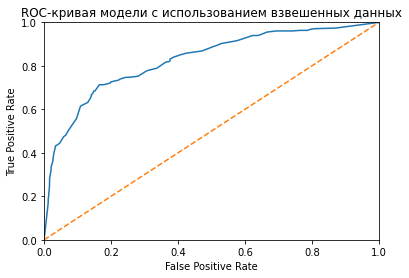


Результат тестирования модели случайного леса на взвешенных данных
AUC-ROC модели на тестовой выборке c использованием взвешенных данных: 0.8613069882063016
F1 модели на тестовой выборке c использованием взвешенных данных: 0.6090808416389812



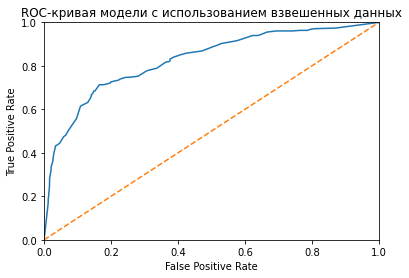

In [194]:
# Тренируем на upsampled данных
print('Результат тестирования модели случайного леса на upsampled данных')
model = RandomForestClassifier(criterion='entropy', max_depth=9, random_state=12345, n_estimators=13)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
score = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
f1 = f1_score(target_test, predicted_test)
print('AUC-ROC модели на тестовой выборке c использованием upsampled данных:', auc_roc)
print('F1 модели на тестовой выборке c использованием upsampled данных:', f1)
print()
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая модели c использованием взвешенных данных')
plt.show()
print()

# Тренируем на взвешенных данных
print('Результат тестирования модели случайного леса на взвешенных данных')
model = RandomForestClassifier(criterion='gini', max_depth=7, class_weight='balanced', random_state=12345, n_estimators=17)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
score = f1_score(target_test, predicted_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
f1 = f1_score(target_test, predicted_test)
print('AUC-ROC модели на тестовой выборке c использованием взвешенных данных:', auc_roc)
print('F1 модели на тестовой выборке c использованием взвешенных данных:', f1)
print()
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая модели c использованием взвешенных данных')
plt.show()



> На тестовой выборке достигла поставленной задачи и только **модель случайного леса** с методом балансировки данных upsample. Значение метрики AUC-ROC при этом коррелирует со значением F1 меры



# Общий вывод

Наиболее успешно прогноризует отток клиентов **модель случайного леса** со сбалансированными данными по методу upsample и гиперпараметрами criterion='entropy', max_depth=9, n_estimators=13

AUC-ROC модели на тестовой выборке c использованием upsampled данных: 0.8669679633867275
F1 модели на тестовой выборке c использованием upsampled данных: 0.6162657502863689

Цель достигнута.